In [13]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [15]:
train_dir = "/content/gdrive/MyDrive/Face Mask Dataset/Train2"
test_dir = "/content/gdrive/MyDrive/Face Mask Dataset/Test"
val_dir = "/content/gdrive/MyDrive/Face Mask Dataset/Validation"

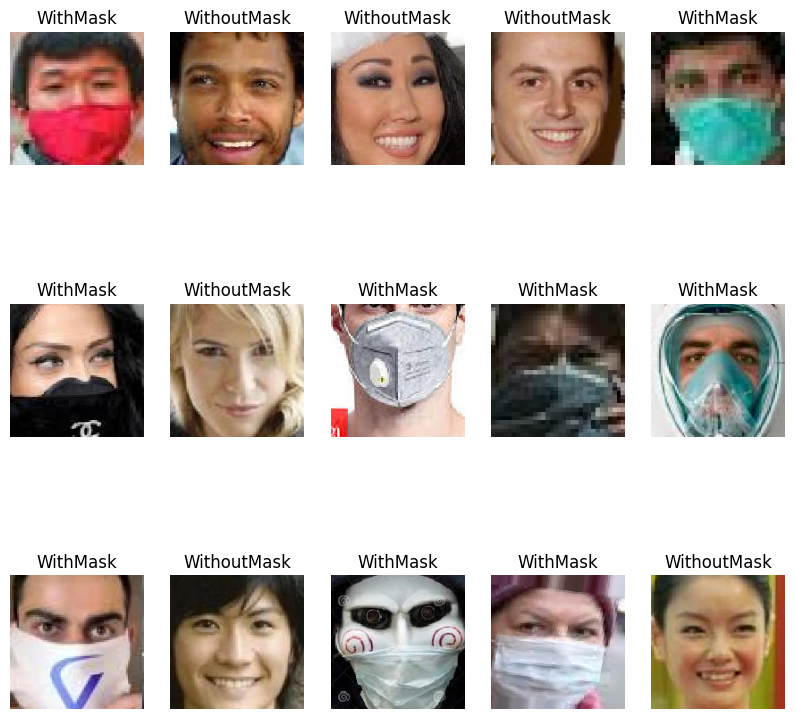

In [16]:
data_train = image_dataset_from_directory(train_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
classes_train = data_train.class_names
plt.figure(figsize=(10,10))
for img, label in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')

clear_output()

In [17]:
classes = next(os.walk(train_dir))[1]
print(classes)

['WithoutMask', 'WithMask']


In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# 1. **InceptionV3**

In [19]:
IMG_SIZE = (256, 256)                    # Image size is (256, 256) for Inception

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 2000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [20]:
inceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in inceptionV3.layers:  # make pre trained model into non trainable to save time and computational cost
    layer.trainable = False

In [21]:
model = Sequential()
model.add(inceptionV3)

model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))    #two classes

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
callback = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.00001,
    patience=3,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
    )

In [23]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [24]:
inception_history = model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs=10,
                        verbose=1,
                        callbacks=callback)

Epoch 1/10
10/10 [==============================] - 108s 11s/step - loss: 4.1719 - accuracy: 0.7215 - val_loss: 1.2554 - val_accuracy: 0.9050
Epoch 2/10
10/10 [==============================] - 56s 6s/step - loss: 1.0578 - accuracy: 0.9270 - val_loss: 0.4020 - val_accuracy: 0.9550
Epoch 3/10
10/10 [==============================] - 62s 6s/step - loss: 0.6061 - accuracy: 0.9515 - val_loss: 0.3045 - val_accuracy: 0.9737
Epoch 4/10
10/10 [==============================] - 55s 6s/step - loss: 0.5288 - accuracy: 0.9600 - val_loss: 0.2471 - val_accuracy: 0.9700
Epoch 5/10
10/10 [==============================] - 55s 6s/step - loss: 0.3927 - accuracy: 0.9685 - val_loss: 0.2171 - val_accuracy: 0.9775
Epoch 6/10
10/10 [==============================] - 55s 5s/step - loss: 0.2994 - accuracy: 0.9715 - val_loss: 0.1922 - val_accuracy: 0.9675
Epoch 7/10
10/10 [==============================] - 54s 5s/step - loss: 0.2007 - accuracy: 0.9725 - val_loss: 0.1188 - val_accuracy: 0.9750
Epoch 8/10
10/10 [

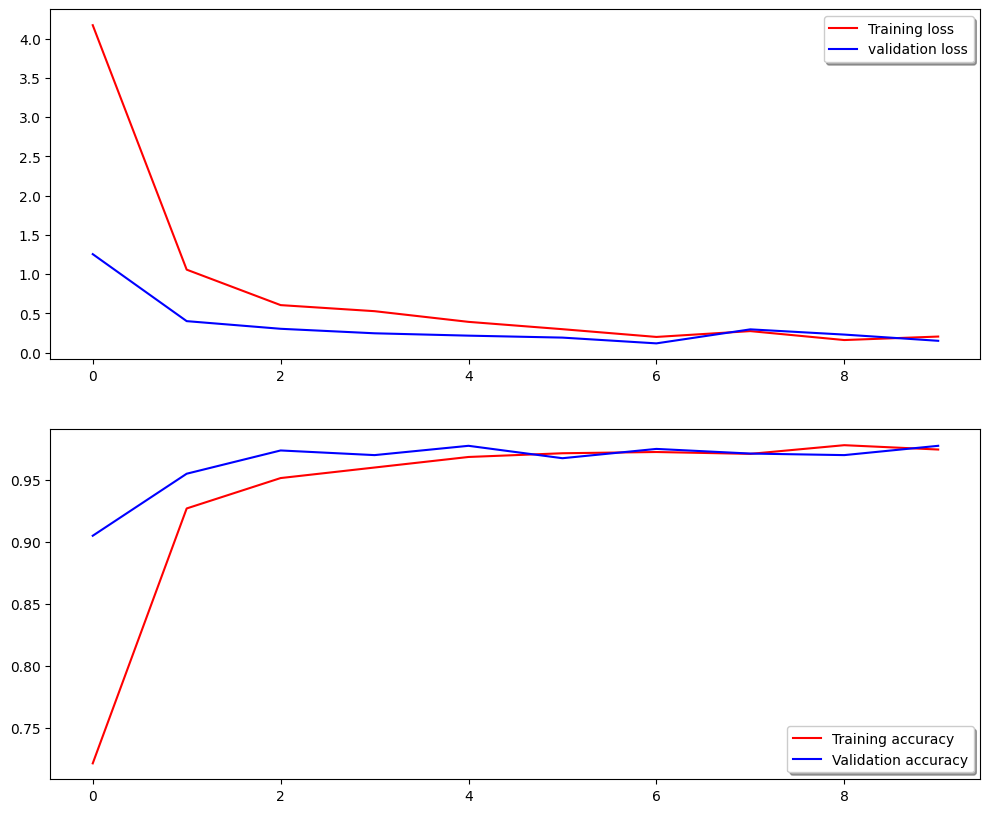

In [25]:
# Loss
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(inception_history.history['loss'], color='r', label="Training loss")
ax[0].plot(inception_history.history['val_loss'], color='b', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Accuracy
ax[1].plot(inception_history.history['accuracy'], color='r', label="Training accuracy")
ax[1].plot(inception_history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [26]:
inception_accuracy = model.evaluate(test_dataset)


16/16 [==============================] - 685s 46s/step - loss: 0.0305 - accuracy: 0.9970


In [27]:
model.save("./inceptionV3.h5")

# **2. ResNet101V2**

In [28]:
IMG_SIZE = (256, 256)                    # Image size is (256, 256) for ResNet

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 2000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [29]:
resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in resnet101v2.layers:
    layer.trainable = False

171317808/171317808 [==============================] - 9s 0us/step


In [30]:
model = Sequential()
model.add(resnet101v2)

model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 8, 8, 2048)        42626560  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 42,888,706
Trainable params: 262,146
Non-trainable params: 42,626,560
_________________________________________________________________


In [31]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [32]:
resnet_history = model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs=10,
                        verbose=1,
                        callbacks=callback)

Epoch 1/10
10/10 [==============================] - 74s 6s/step - loss: 11.1567 - accuracy: 0.7310 - val_loss: 8.4796 - val_accuracy: 0.8525
Epoch 2/10
10/10 [==============================] - 55s 6s/step - loss: 3.1367 - accuracy: 0.9080 - val_loss: 3.1236 - val_accuracy: 0.9075
Epoch 3/10
10/10 [==============================] - 54s 6s/step - loss: 1.2240 - accuracy: 0.9535 - val_loss: 1.2107 - val_accuracy: 0.9588
Epoch 4/10
10/10 [==============================] - 54s 6s/step - loss: 0.9818 - accuracy: 0.9615 - val_loss: 1.0028 - val_accuracy: 0.9663
Epoch 5/10
10/10 [==============================] - 56s 6s/step - loss: 0.5407 - accuracy: 0.9780 - val_loss: 0.8608 - val_accuracy: 0.9525
Epoch 6/10
10/10 [==============================] - 58s 6s/step - loss: 0.7310 - accuracy: 0.9720 - val_loss: 0.5144 - val_accuracy: 0.9700
Epoch 7/10
10/10 [==============================] - 54s 6s/step - loss: 0.5732 - accuracy: 0.9755 - val_loss: 0.8954 - val_accuracy: 0.9675
Epoch 8/10
10/10 [=

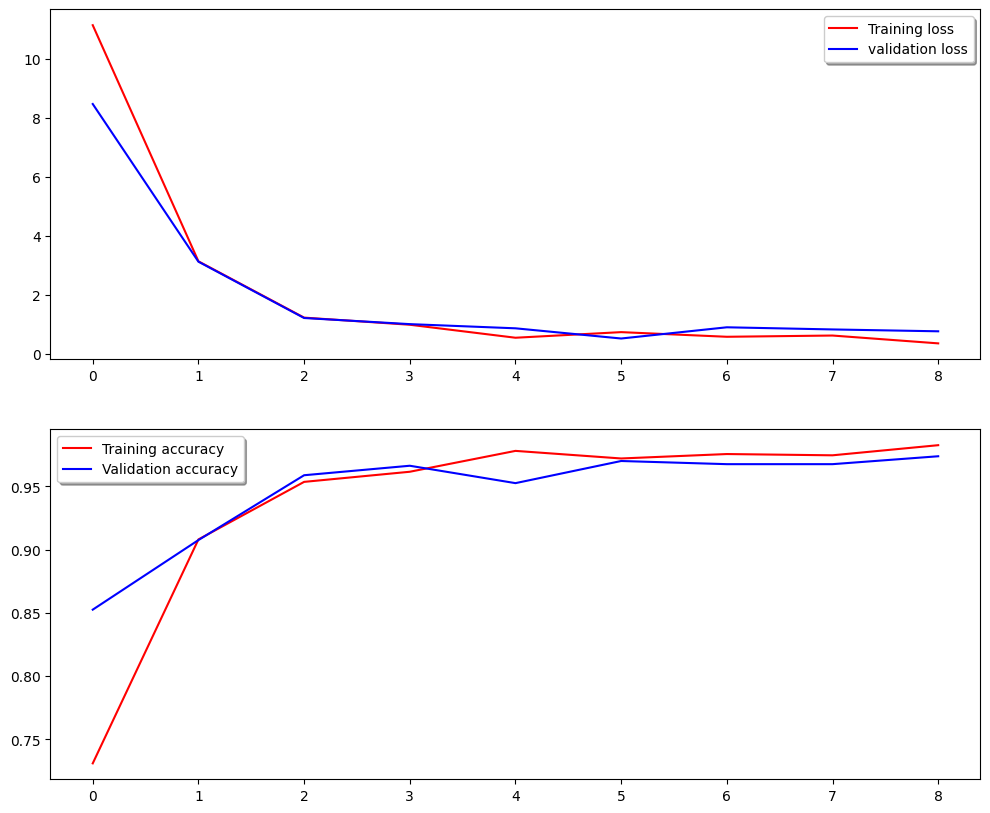

In [33]:
# Loss
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(resnet_history.history['loss'], color='r', label="Training loss")
ax[0].plot(resnet_history.history['val_loss'], color='b', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Accuracy
ax[1].plot(resnet_history.history['accuracy'], color='r', label="Training accuracy")
ax[1].plot(resnet_history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [34]:
resnet_accuracy = model.evaluate(test_dataset)

16/16 [==============================] - 6s 355ms/step - loss: 0.0821 - accuracy: 0.9970


In [35]:
model.save("./resnet101v2.h5")

# **3. VGG19**

In [36]:
IMG_SIZE = (224, 224)                    # Image size is (224, 224) for VGG19

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 2000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [37]:
vgg19 = VGG19(weights='imagenet',
              include_top=False,
              input_shape=(224,224,3))

for layer in vgg19.layers:
    layer.trainable = False


model = Sequential()
model.add(vgg19)

model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [38]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [39]:
vgg19_history = model.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=10,
                          verbose=1,
                          callbacks=callback)

Epoch 1/10
10/10 [==============================] - 85s 6s/step - loss: 0.5971 - accuracy: 0.7585 - val_loss: 0.1055 - val_accuracy: 0.9588
Epoch 2/10
10/10 [==============================] - 44s 4s/step - loss: 0.1630 - accuracy: 0.9410 - val_loss: 0.1056 - val_accuracy: 0.9650
Epoch 3/10
10/10 [==============================] - 44s 5s/step - loss: 0.1015 - accuracy: 0.9710 - val_loss: 0.0945 - val_accuracy: 0.9663
Epoch 4/10
10/10 [==============================] - 44s 4s/step - loss: 0.0621 - accuracy: 0.9760 - val_loss: 0.0550 - val_accuracy: 0.9825
Epoch 5/10
10/10 [==============================] - 44s 4s/step - loss: 0.0483 - accuracy: 0.9845 - val_loss: 0.0529 - val_accuracy: 0.9825
Epoch 6/10
10/10 [==============================] - 44s 4s/step - loss: 0.0461 - accuracy: 0.9830 - val_loss: 0.0341 - val_accuracy: 0.9900
Epoch 7/10
10/10 [==============================] - 44s 4s/step - loss: 0.0432 - accuracy: 0.9835 - val_loss: 0.0377 - val_accuracy: 0.9850
Epoch 8/10
10/10 [==

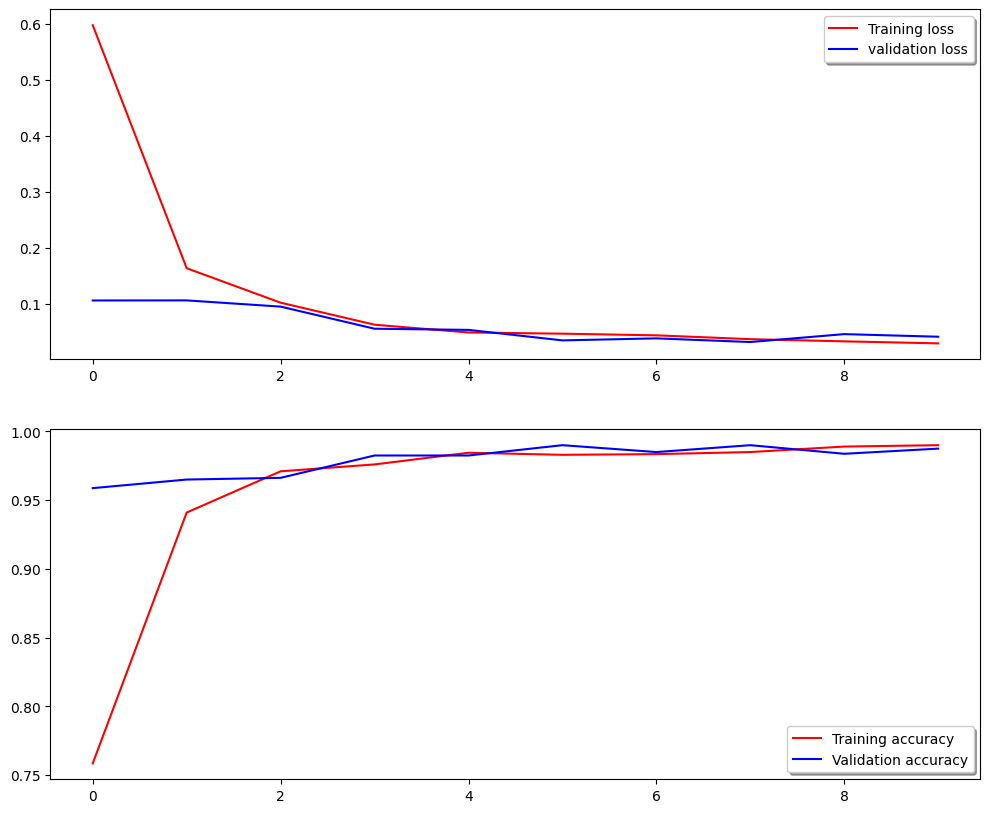

In [40]:
# Loss
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(vgg19_history.history['loss'], color='r', label="Training loss")
ax[0].plot(vgg19_history.history['val_loss'], color='b', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Accuracy
ax[1].plot(vgg19_history.history['accuracy'], color='r', label="Training accuracy")
ax[1].plot(vgg19_history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [41]:
vgg19_accuracy = model.evaluate(test_dataset)


16/16 [==============================] - 6s 331ms/step - loss: 0.1772 - accuracy: 0.9345


In [42]:
model.save("./vgg19.h5")

# **4. VGG16**

In [43]:
IMG_SIZE = (224, 224)                    # Image size is (224, 224) for VGG16

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 2000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [44]:
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(224,224,3))

for layer in vgg16.layers:
    layer.trainable = False


model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [45]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [46]:
vgg16_history = model.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=10,
                          verbose=1,
                          callbacks=callback)

Epoch 1/10
10/10 [==============================] - 55s 6s/step - loss: 0.7952 - accuracy: 0.7065 - val_loss: 0.2585 - val_accuracy: 0.8988
Epoch 2/10
10/10 [==============================] - 43s 4s/step - loss: 0.1429 - accuracy: 0.9460 - val_loss: 0.1113 - val_accuracy: 0.9575
Epoch 3/10
10/10 [==============================] - 42s 4s/step - loss: 0.0816 - accuracy: 0.9735 - val_loss: 0.0581 - val_accuracy: 0.9812
Epoch 4/10
10/10 [==============================] - 44s 4s/step - loss: 0.0633 - accuracy: 0.9775 - val_loss: 0.0393 - val_accuracy: 0.9875
Epoch 5/10
10/10 [==============================] - 51s 5s/step - loss: 0.0518 - accuracy: 0.9810 - val_loss: 0.0324 - val_accuracy: 0.9887
Epoch 6/10
10/10 [==============================] - 42s 4s/step - loss: 0.0434 - accuracy: 0.9875 - val_loss: 0.0362 - val_accuracy: 0.9875
Epoch 7/10
10/10 [==============================] - 52s 5s/step - loss: 0.0315 - accuracy: 0.9890 - val_loss: 0.0310 - val_accuracy: 0.9925
Epoch 8/10
10/10 [==

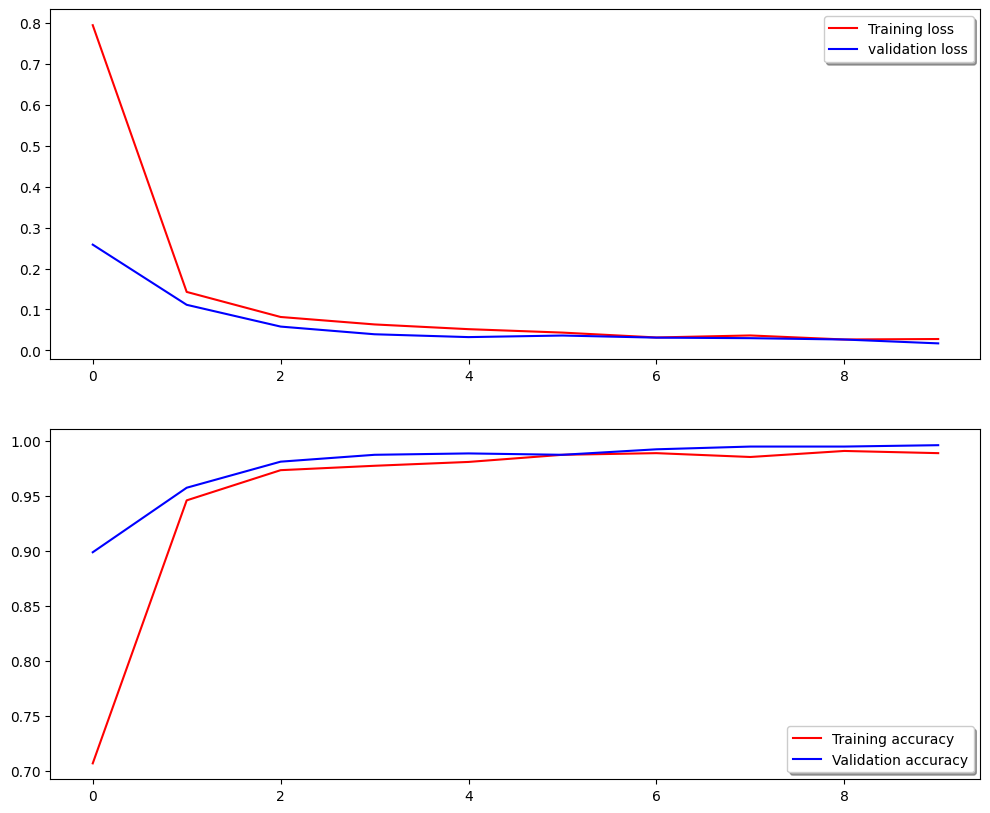

In [47]:
# Loss
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(vgg16_history.history['loss'], color='r', label="Training loss")
ax[0].plot(vgg16_history.history['val_loss'], color='b', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Accuracy
ax[1].plot(vgg16_history.history['accuracy'], color='r', label="Training accuracy")
ax[1].plot(vgg16_history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [48]:
vgg16_accuracy = model.evaluate(test_dataset)

16/16 [==============================] - 5s 276ms/step - loss: 0.1214 - accuracy: 0.9708


In [49]:
model.save("./vgg16.h5")


# **5. MobileNetV2**

In [50]:
IMG_SIZE = (150, 150)                    # image size is (150,150) for MobileNet

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 2000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [51]:
mobilenet = MobileNetV2(weights = "imagenet",
                        include_top = False,
                        input_shape=(150,150,3))
for layer in mobilenet.layers:
    layer.trainable = False


model = Sequential()
model.add(mobilenet)

model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_5 (Flatten)         (None, 32000)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 64002     
                                                                 
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [52]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [53]:
mobilenet_history = model.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=10,
                          verbose=1,
                          callbacks=callback)

Epoch 1/10
10/10 [==============================] - 27s 2s/step - loss: 0.7742 - accuracy: 0.8615 - val_loss: 0.2302 - val_accuracy: 0.9775
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.2492 - accuracy: 0.9675 - val_loss: 0.2337 - val_accuracy: 0.9762
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.2205 - accuracy: 0.9730 - val_loss: 0.2157 - val_accuracy: 0.9762
Epoch 4/10
10/10 [==============================] - 22s 2s/step - loss: 0.1146 - accuracy: 0.9850 - val_loss: 0.1017 - val_accuracy: 0.9837
Epoch 5/10
10/10 [==============================] - 21s 2s/step - loss: 0.0957 - accuracy: 0.9870 - val_loss: 0.1513 - val_accuracy: 0.9800
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.0805 - accuracy: 0.9840 - val_loss: 0.1104 - val_accuracy: 0.9850
Epoch 7/10
10/10 [==============================] - 21s 2s/step - loss: 0.0943 - accuracy: 0.9830 - val_loss: 0.1446 - val_accuracy: 0.9762
Epoch 7: early stopp

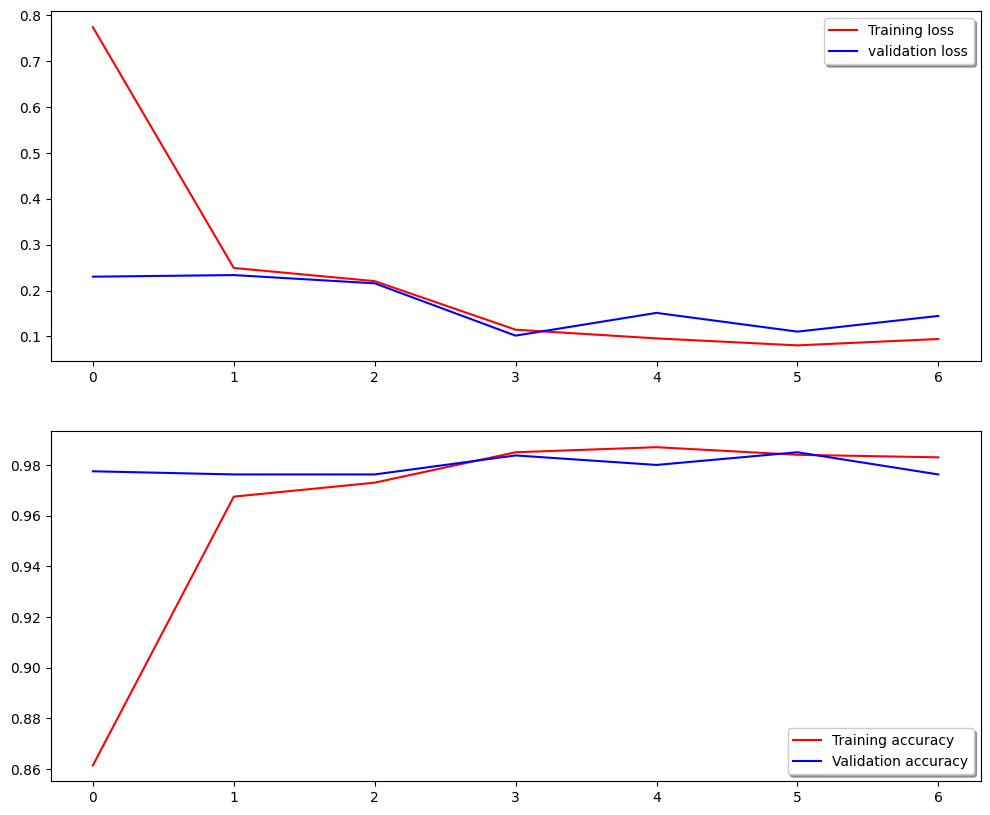

In [54]:
# Loss
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(mobilenet_history.history['loss'], color='r', label="Training loss")
ax[0].plot(mobilenet_history.history['val_loss'], color='b', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Accuracy
ax[1].plot(mobilenet_history.history['accuracy'], color='r', label="Training accuracy")
ax[1].plot(mobilenet_history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [55]:
mobilenet_accuracy = model.evaluate(test_dataset)


16/16 [==============================] - 3s 199ms/step - loss: 0.1102 - accuracy: 0.9788


In [56]:
model.save("./mobilenet.h5")

# **6. DenseNet201**

In [57]:
IMG_SIZE = (128, 128)                    # image size is (128, 128) for DenseNet201

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 2000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [58]:
densenet = DenseNet201(weights = "imagenet",
                       include_top = False,
                       input_shape=(128,128,3))
for layer in densenet.layers:
    layer.trainable = False


model = Sequential()
model.add(densenet)

model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.summary()

74836368/74836368 [==============================] - 5s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten_6 (Flatten)         (None, 30720)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 61442     
                                                                 
Total params: 18,383,426
Trainable params: 61,442
Non-trainable params: 18,321,984
_________________________________________________________________


In [59]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [60]:
densenet_history = model.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=10,
                          verbose=1,
                          callbacks=callback)

Epoch 1/10
10/10 [==============================] - 52s 4s/step - loss: 1.1064 - accuracy: 0.8255 - val_loss: 0.0114 - val_accuracy: 0.9962
Epoch 2/10
10/10 [==============================] - 18s 2s/step - loss: 0.0958 - accuracy: 0.9825 - val_loss: 0.0685 - val_accuracy: 0.9800
Epoch 3/10
10/10 [==============================] - 19s 2s/step - loss: 0.0847 - accuracy: 0.9895 - val_loss: 0.0107 - val_accuracy: 0.9962
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 0.0475 - accuracy: 0.9930 - val_loss: 0.0139 - val_accuracy: 0.9962
Epoch 5/10
10/10 [==============================] - 23s 2s/step - loss: 0.0710 - accuracy: 0.9895 - val_loss: 0.0110 - val_accuracy: 0.9950
Epoch 6/10
10/10 [==============================] - 18s 2s/step - loss: 0.0774 - accuracy: 0.9925 - val_loss: 0.0098 - val_accuracy: 0.9962
Epoch 7/10
10/10 [==============================] - 23s 2s/step - loss: 0.0368 - accuracy: 0.9935 - val_loss: 0.0291 - val_accuracy: 0.9925
Epoch 8/10
10/10 [==

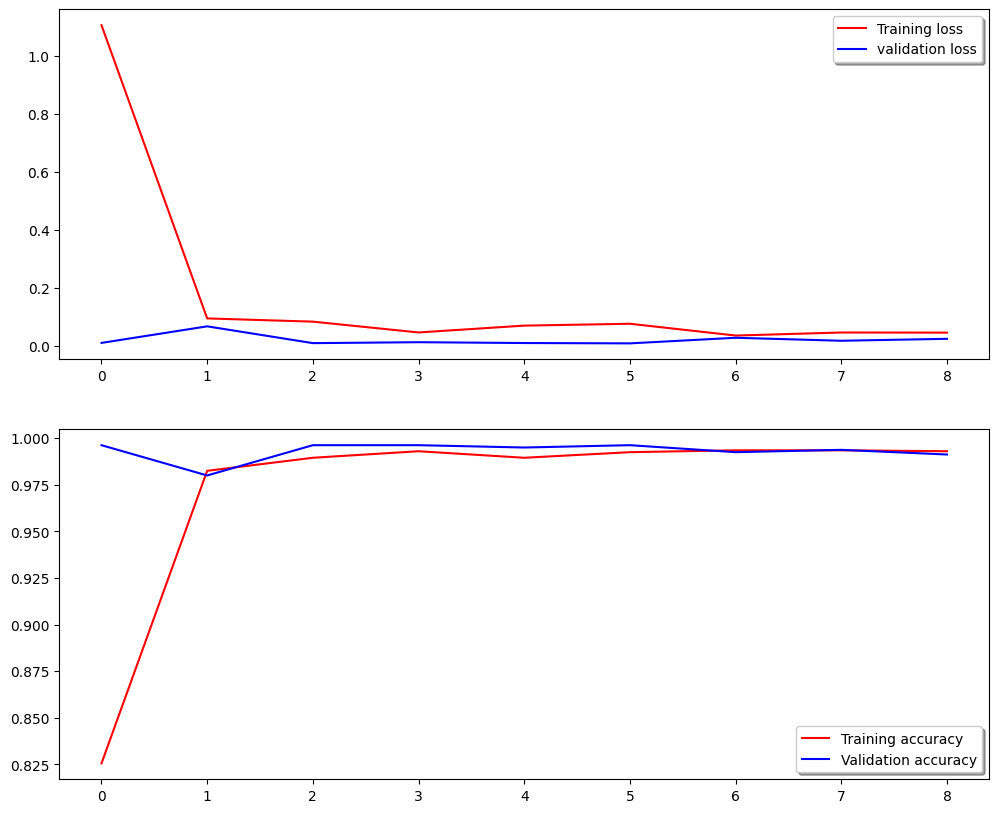

In [61]:
# Loss
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(densenet_history.history['loss'], color='r', label="Training loss")
ax[0].plot(densenet_history.history['val_loss'], color='b', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Accuracy
ax[1].plot(densenet_history.history['accuracy'], color='r', label="Training accuracy")
ax[1].plot(densenet_history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [62]:
densenet_accuracy = model.evaluate(test_dataset)

16/16 [==============================] - 3s 169ms/step - loss: 0.0315 - accuracy: 0.9909


In [63]:
model.save("./densenet.h5")

# **Comparison of the models**

In [64]:
model_histories = [inception_history, resnet_history ,vgg19_history ,
                   vgg16_history ,mobilenet_history,densenet_history]
names = ['InceptionV3','ResNet101V2', 'VGG19', 'VGG16', 'MobileNetV2','DenseNet201']

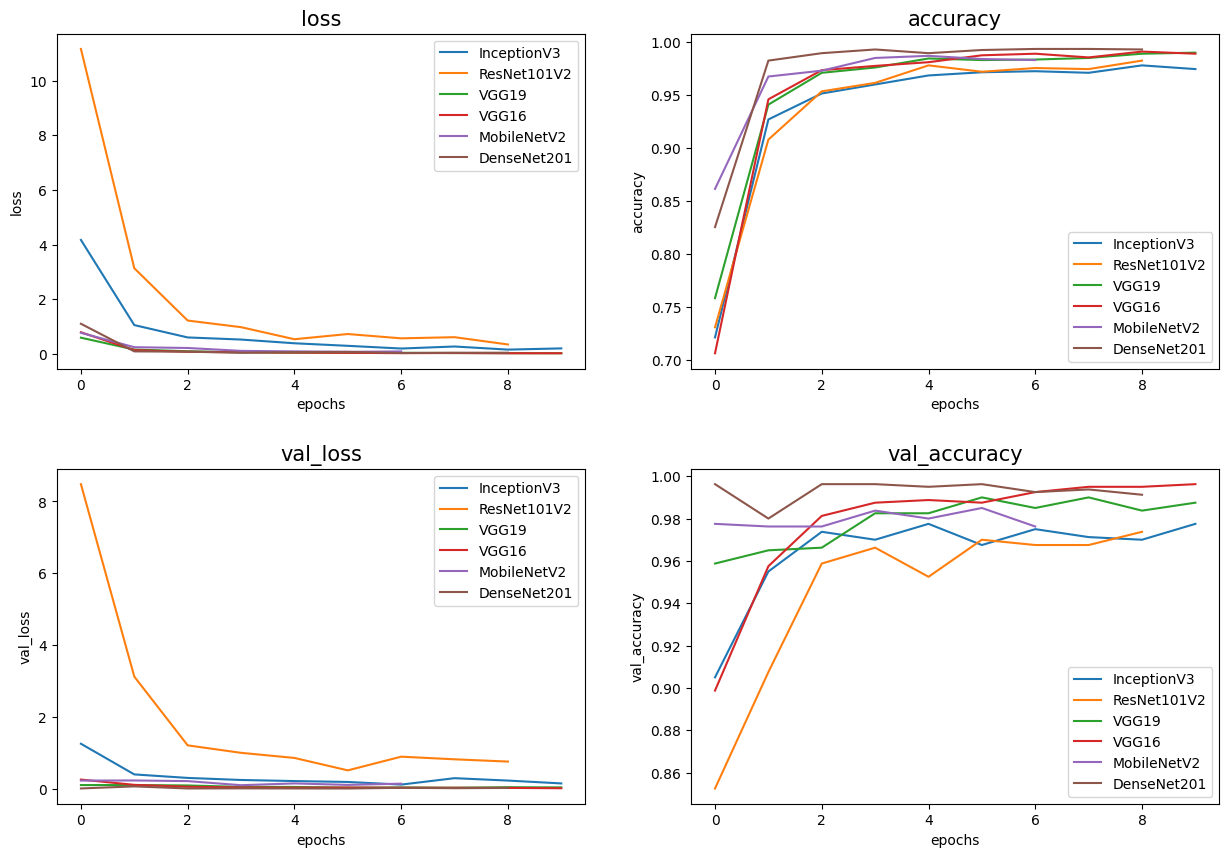

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_histories[0].history:
    index = list(model_histories[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_histories:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric, size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()

In [66]:
data={'Nets':['InceptionV3','ResNet101V2', 'VGG19', 'VGG16', 'MobileNetV2','DenseNet201'],
      'Accuracy':[inception_accuracy[1],resnet_accuracy[1],vgg19_accuracy[1],vgg16_accuracy[1],
                  mobilenet_accuracy[1],densenet_accuracy[1]]}

df =pd.DataFrame(data)
df.sort_values('Accuracy', ascending=False)

,Nets,Accuracy
0,InceptionV3,0.996976
1,ResNet101V2,0.996976
5,DenseNet201,0.990927
4,MobileNetV2,0.978831
3,VGG16,0.970766
2,VGG19,0.934476
